#Датасет

Все нижеперечисленные модели были обучены на данных исходного датасета: метрики качества сильно зависели от разбиения на обучающущую и валидационную выборки. Модели сильно переобучались, точность на валидации была меньше 0.6. Поэтому мы решили увеличить датасет. Для этого мы использовали ChatGPT, который нагенерировал нам еще 700 элементов для обучения и валидации. Их мы добавили к исходному датасету (файл "task-3-dataset_aug.csv").
Тестирование моделей производилось на 100 элементах из ИСХОДНОГО дастасета. Поэтому мы считаем наши результаты достаточно объективными.

#Эмбеддинг

Для того чтобы решать задачу классификации отзыввов, необходимо перейти к векторному представлению слов (так называемый эмбеддинг). Для того чтобы сделать эмбеддинг мы использовали предобученную под работу с рускоязычными текстами нейросеть RuBERT. Мы пропускали отзыв через нейросеть и брали в качестве эмбеддинга один из векторов последнего скрытого слоя(hidden layer). Следствие архитектуры трансформера, является то, что полученный таким образом эмбеддинг хранит в себе информацию обо всем отзыве сразу.

In [1]:
import transformers

model_name = "DeepPavlov/rubert-base-cased"
model = transformers.AutoModel.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
import pandas as pd

data = pd.read_csv("task-3-dataset_aug.csv")

In [4]:
from tqdm import tqdm
Embedding = []
Target = []
for i in tqdm(range(210)):
  sentence = data["отзывы"][i]
  tokenized = tokenizer(sentence, return_tensors="pt")
  embeddings = model(**tokenized, output_hidden_states=True).last_hidden_state
  Embedding.append(embeddings[0][1])
  del embeddings
  if data["разметка"][i][0] == "+":
    Target.append(1)
  elif data["разметка"][i][0] == "-":
    Target.append(0)

for i in tqdm(range(250,600)):
  sentence = data["отзывы"][i]
  tokenized = tokenizer(sentence, return_tensors="pt")
  embeddings = model(**tokenized, output_hidden_states=True).last_hidden_state
  Embedding.append(embeddings[0][1])
  del embeddings

  if data["разметка"][i][0] == "+":
    Target.append(1)
  elif data["разметка"][i][0] == "-":
    Target.append(0)

for i in tqdm(range(700,1050)):
  sentence = data["отзывы"][i]
  tokenized = tokenizer(sentence, return_tensors="pt")
  embeddings = model(**tokenized, output_hidden_states=True).last_hidden_state
  Embedding.append(embeddings[0][1])
  del embeddings
  if data["разметка"][i][0] == "+":
    Target.append(1)
  elif data["разметка"][i][0] == "-":
    Target.append(0)

100%|██████████| 350/350 [00:38<00:00,  9.21it/s]


#Classical NN

##Архитектура модели

In [25]:
import numpy as np
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(
            self,
            input_size = 768,
            first_layer_neurons = 400,
            second_layer_neurons = 100,
            lin3_length=3e-2
    ):
        super().__init__()
        self.input_size = input_size
        self.first_layer_neurons = first_layer_neurons
        self.second_layer_neurons = second_layer_neurons
        self.max_neurons = max(self.first_layer_neurons, self.second_layer_neurons)

        lin1 = nn.Linear(self.input_size, self.first_layer_neurons)

        lin2 = nn.Linear(self.first_layer_neurons, self.second_layer_neurons)
        lin3 = nn.Linear(self.second_layer_neurons, 2)
        self.fc = nn.Sequential(
            lin1,
            nn.ReLU(),
            lin2,
            nn.ReLU(),
            lin3)
    def forward(self, x):
      return F.log_softmax(self.fc(x), dim=1)


##Генерация датасета

In [58]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, target):
        super().__init__()
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y = self.target[idx]

        return X, y

train_dataset = CustomDataset(Embedding[100:], Target[100:])
test_dataset =CustomDataset(Embedding[:100], Target[:100])

In [59]:
import time
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models.vision_transformer import MLPBlock

### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = []
    accuracy=0
    for embed, y in dataloader:
        embed = embed.detach().to(device)
        y = y.to(device)
        # Embedded data
        pred = model(embed)
        # Accuracy
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        # Loss function
        loss = loss_fn(pred, y)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss), accuracy/len(dataloader)

### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        accuracy=0
        for embed, y in dataloader:
            # Move tensor to the proper device
            embed = embed.to(device)
            y = y.to(device)
            # Decode data
            pred = model(embed)
            # Accuracy
            ps = torch.exp(pred)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            conc_out.append(pred.cpu())
            conc_label.append(y.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data, accuracy/len(dataloader)


In [60]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size=10
lr = 0.00005

m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

loss_fn = nn.NLLLoss()

mlp_model =  MLP()
optim = torch.optim.Adam(mlp_model.parameters(), lr=lr, weight_decay=1e-05)

num_epochs = 150
diz_loss = {'train_loss': [], 'val_loss': []}
diz_acc = {'train_acc': [], 'val_acc': []}
all_dur = 0
for epoch in range(num_epochs):
    start = time.time()
    train_loss, train_acc = train_epoch(mlp_model, device, train_loader, loss_fn, optim)
    val_loss, val_acc = test_epoch(mlp_model, device, valid_loader, loss_fn)
    end = time.time()
    dur = end - start
    all_dur += dur
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    print('\n EPOCH {}/{} \t train accuracy {} \t val accuracy {}'.format(epoch + 1,
                                                                          num_epochs, train_acc, val_acc))
    print("Duration of EPOCH: {} sec. Approximately remaining time of training: {} sec ({} min)".format(
        round(dur, 1),
        round(all_dur / (epoch + 1) * num_epochs - all_dur, 1),
        round(all_dur / (epoch + 1) * num_epochs / 60 - all_dur / 60, 1)))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss.item())
    diz_acc['train_acc'].append(train_acc.item())
    diz_acc['val_acc'].append(val_acc.item())
    if train_acc > 0.99:
        break


 EPOCH 1/150 	 train loss 0.6090012788772583 	 val loss 0.5071048736572266

 EPOCH 1/150 	 train accuracy 0.7626923322677612 	 val accuracy 0.8999999761581421
Duration of EPOCH: 0.3 sec. Approximately remaining time of training: 45.1 sec (0.8 min)

 EPOCH 2/150 	 train loss 0.41696956753730774 	 val loss 0.3191365599632263

 EPOCH 2/150 	 train accuracy 0.9261540770530701 	 val accuracy 0.9588235020637512
Duration of EPOCH: 0.4 sec. Approximately remaining time of training: 50.2 sec (0.8 min)

 EPOCH 3/150 	 train loss 0.2547557055950165 	 val loss 0.2136232554912567

 EPOCH 3/150 	 train accuracy 0.9369232058525085 	 val accuracy 0.9647058844566345
Duration of EPOCH: 0.4 sec. Approximately remaining time of training: 51.4 sec (0.9 min)

 EPOCH 4/150 	 train loss 0.17061825096607208 	 val loss 0.15959320962429047

 EPOCH 4/150 	 train accuracy 0.9553847312927246 	 val accuracy 0.970588207244873
Duration of EPOCH: 0.3 sec. Approximately remaining time of training: 50.6 sec (0.8 min)

 

In [61]:
test_loss, test_acc = test_epoch(mlp_model, device, test_loader, loss_fn)
print('Loss and Acc:', test_loss, test_acc)

Loss and Acc: tensor(0.5452) tensor(0.7400)


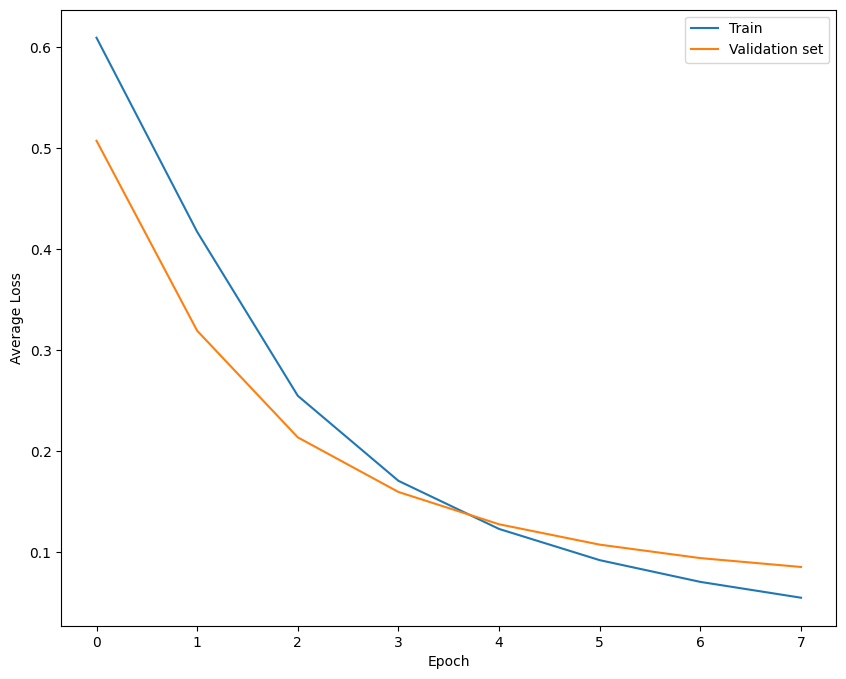

In [62]:
plt.figure(figsize=(10,8))
plt.plot(diz_loss['train_loss'], label='Train')
plt.plot(np.array(diz_loss['val_loss']), label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

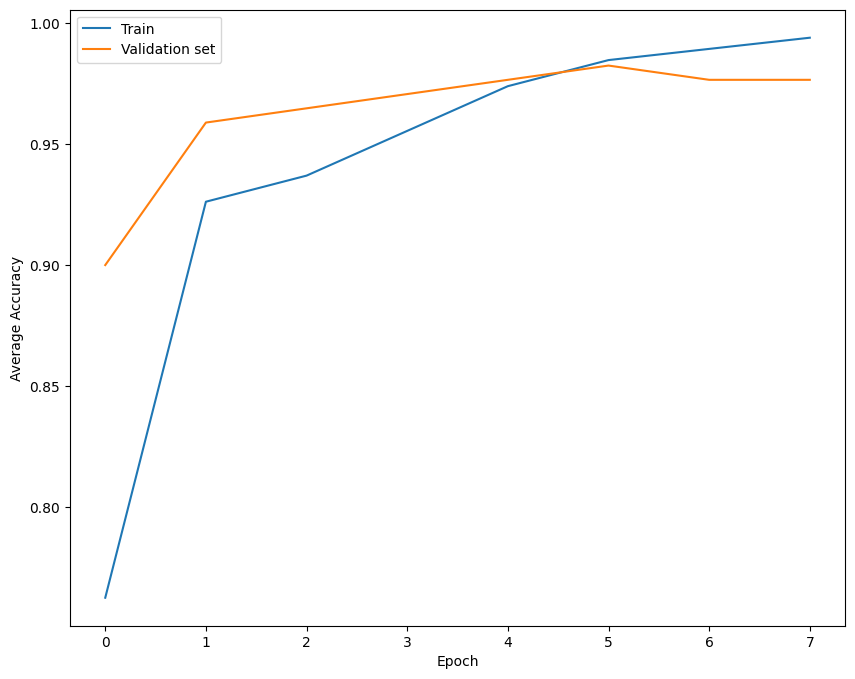

In [63]:
plt.figure(figsize=(10,8))
plt.plot(diz_acc['train_acc'], label='Train')
plt.plot(np.array(diz_acc['val_acc']), label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
#plt.grid()
plt.legend()
# plt.ylim(0.9,1.001)
#plt.title('loss')
# plt.ticklabel_format(useOffset=False)
plt.show()

# Hybrid NN

In [19]:
!pip install qiskit
!pip install qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 11.9 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512554 sha256=71450d9814e0a387d1ea4d6b88d135f527897b13cbf31bc18a6677c0306a128b
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [32]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


In [33]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

##Архитектура модели

###Квантовый слой

In [49]:
def create_qnn(qbit = 2, reps=1):
    feature_map = ZZFeatureMap(qbit)
    ansatz = RealAmplitudes(qbit, reps=reps)
    qc = QuantumCircuit(qbit)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

Визуализация квантового слоя для q=3

In [ ]:
!pip install pylatexenc

Feature map

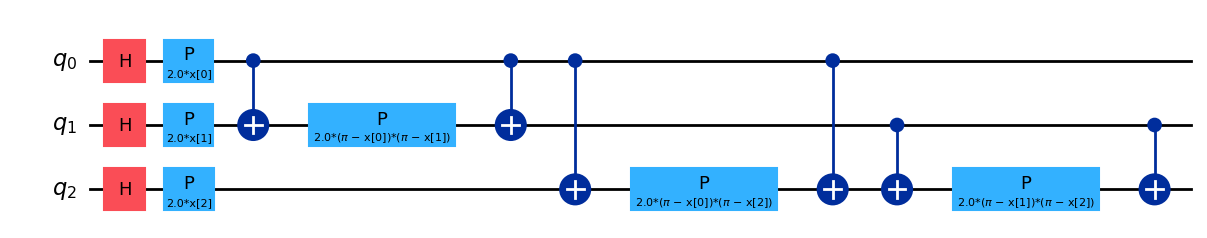

In [74]:
fm = ZZFeatureMap(3, reps=1)
fm.decompose().draw("mpl")

Ansatz

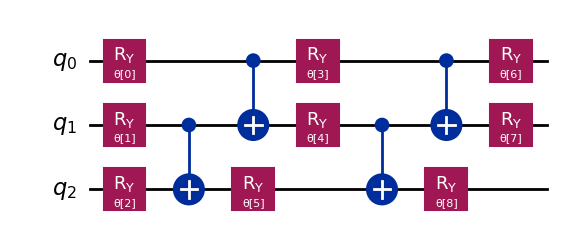

In [75]:
an = RealAmplitudes(3, reps=2)
an.decompose().draw("mpl")

In [51]:
# Define torch NN module

class Net(Module):
    def __init__(self, qbit = 2, reps=1):
        super().__init__()

        self.fc1 = Linear(768, 400)
        self.fc2 = Linear(400, 100)
        self.fc3 = Linear(100,qbit)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(create_qnn(qbit, reps))  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc4 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return cat((x, 1 - x), -1)

In [36]:
train_dataset = CustomDataset(Embedding[100:], Target[100:])
test_dataset =CustomDataset(Embedding[:100], Target[:100])

#2 qubit

In [54]:
batch_size=20
lr = 0.0008

m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

q_model =  Net(qbit = 2, reps=1)
optim = torch.optim.Adam(q_model.parameters(), lr=lr, weight_decay=1e-05)

num_epochs = 150
diz_loss = {'train_loss': [], 'val_loss': []}
diz_acc = {'train_acc': [], 'val_acc': []}
all_dur = 0
for epoch in range(num_epochs):
    start = time.time()
    train_loss, train_acc = train_epoch(q_model, device, train_loader, loss_fn, optim)
    val_loss, val_acc = test_epoch(q_model, device, valid_loader, loss_fn)
    end = time.time()
    dur = end - start
    all_dur += dur
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    print('\n EPOCH {}/{} \t train accuracy {} \t val accuracy {}'.format(epoch + 1,
                                                                          num_epochs, train_acc, val_acc))
    print("Duration of EPOCH: {} sec. Approximately remaining time of training: {} sec ({} min)".format(
        round(dur, 1),
        round(all_dur / (epoch + 1) * num_epochs - all_dur, 1),
        round(all_dur / (epoch + 1) * num_epochs / 60 - all_dur / 60, 1)))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss.item())
    diz_acc['train_acc'].append(train_acc.item())
    diz_acc['val_acc'].append(val_acc.item())
    if train_acc > 0.99 and val_acc>0.98:
        break


<ipython-input-49-8d525dc1955b>:8: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
<ipython-input-49-8d525dc1955b>:8: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (2). If `circuit` is transpiled, this may cause unstable behaviour.
  qnn = EstimatorQNN(



 EPOCH 1/150 	 train loss -0.9294876456260681 	 val loss -1.0372731685638428

 EPOCH 1/150 	 train accuracy 0.8666666150093079 	 val accuracy 0.9055554866790771
Duration of EPOCH: 28.5 sec. Approximately remaining time of training: 4253.6 sec (70.9 min)

 EPOCH 2/150 	 train loss -1.1156818866729736 	 val loss -1.1345021724700928

 EPOCH 2/150 	 train accuracy 0.9696969985961914 	 val accuracy 0.9611110687255859
Duration of EPOCH: 23.2 sec. Approximately remaining time of training: 3826.1 sec (63.8 min)

 EPOCH 3/150 	 train loss -1.223328948020935 	 val loss -1.2022840976715088

 EPOCH 3/150 	 train accuracy 0.9909090995788574 	 val accuracy 0.9777777194976807
Duration of EPOCH: 24.4 sec. Approximately remaining time of training: 3731.1 sec (62.2 min)

 EPOCH 4/150 	 train loss -1.272879958152771 	 val loss -1.2147291898727417

 EPOCH 4/150 	 train accuracy 0.9924242496490479 	 val accuracy 0.9722222089767456
Duration of EPOCH: 29.6 sec. Approximately remaining time of training: 3860

KeyboardInterrupt: 

In [55]:
test_loss, test_acc = test_epoch(q_model, device, test_loader, loss_fn)
print('Loss and Acc:', test_loss, test_acc)

Loss and Acc: tensor(-0.8729) tensor(0.7500)


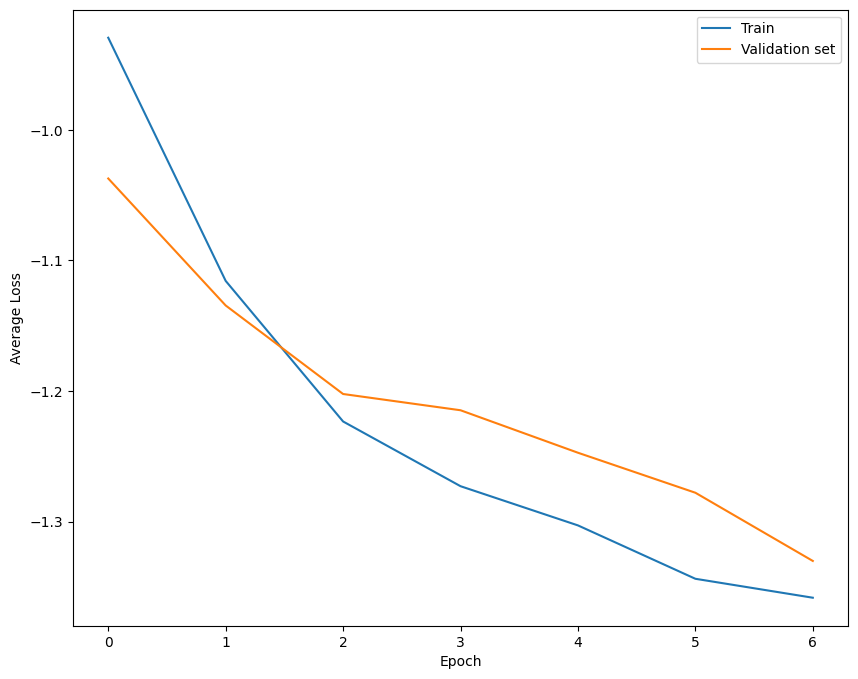

In [56]:
plt.figure(figsize=(10,8))
plt.plot(diz_loss['train_loss'], label='Train')
plt.plot(np.array(diz_loss['val_loss']), label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

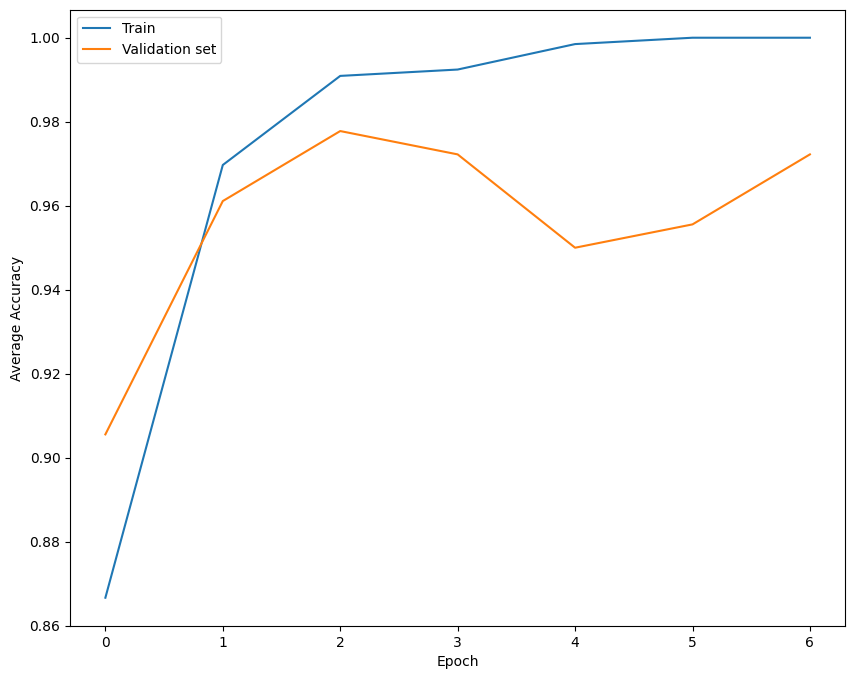

In [57]:
plt.figure(figsize=(10,8))
plt.plot(diz_acc['train_acc'], label='Train')
plt.plot(np.array(diz_acc['val_acc']), label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

In [64]:
torch.save(q_model.state_dict(), "q_model_2qubits_75acc.pt")

In [ ]:
#qnn5 = create_qnn()
#model5 = Net(qnn5)
#model5.load_state_dict(torch.load("q_model.pt"))


#3 qubits


In [66]:
batch_size=20
lr = 0.0008

m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

q_model =  Net(qbit = 3, reps=1)
optim = torch.optim.Adam(q_model.parameters(), lr=lr, weight_decay=1e-05)

num_epochs = 150
diz_loss = {'train_loss': [], 'val_loss': []}
diz_acc = {'train_acc': [], 'val_acc': []}
all_dur = 0
for epoch in range(num_epochs):
    start = time.time()
    train_loss, train_acc = train_epoch(q_model, device, train_loader, loss_fn, optim)
    val_loss, val_acc = test_epoch(q_model, device, valid_loader, loss_fn)
    end = time.time()
    dur = end - start
    all_dur += dur
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    print('\n EPOCH {}/{} \t train accuracy {} \t val accuracy {}'.format(epoch + 1,
                                                                          num_epochs, train_acc, val_acc))
    print("Duration of EPOCH: {} sec. Approximately remaining time of training: {} sec ({} min)".format(
        round(dur, 1),
        round(all_dur / (epoch + 1) * num_epochs - all_dur, 1),
        round(all_dur / (epoch + 1) * num_epochs / 60 - all_dur / 60, 1)))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss.item())
    diz_acc['train_acc'].append(train_acc.item())
    diz_acc['val_acc'].append(val_acc.item())
    if train_acc > 0.99 and val_acc>0.98:
        break

<ipython-input-49-8d525dc1955b>:8: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
<ipython-input-49-8d525dc1955b>:8: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (3). If `circuit` is transpiled, this may cause unstable behaviour.
  qnn = EstimatorQNN(



 EPOCH 1/150 	 train loss -0.6845137476921082 	 val loss -0.8568431735038757

 EPOCH 1/150 	 train accuracy 0.6007574796676636 	 val accuracy 0.8611111044883728
Duration of EPOCH: 77.4 sec. Approximately remaining time of training: 11529.7 sec (192.2 min)

 EPOCH 2/150 	 train loss -0.8682035207748413 	 val loss -0.9677892327308655

 EPOCH 2/150 	 train accuracy 0.8727273344993591 	 val accuracy 0.9444444179534912
Duration of EPOCH: 75.7 sec. Approximately remaining time of training: 11329.8 sec (188.8 min)

 EPOCH 3/150 	 train loss -0.9465823769569397 	 val loss -1.0167871713638306

 EPOCH 3/150 	 train accuracy 0.9560605883598328 	 val accuracy 0.9666666388511658
Duration of EPOCH: 74.9 sec. Approximately remaining time of training: 11173.1 sec (186.2 min)

 EPOCH 4/150 	 train loss -0.996665358543396 	 val loss -1.046626091003418

 EPOCH 4/150 	 train accuracy 0.9772727489471436 	 val accuracy 0.9666667580604553
Duration of EPOCH: 75.2 sec. Approximately remaining time of training

In [67]:
test_loss, test_acc = test_epoch(q_model, device, test_loader, loss_fn)
print('Loss and Acc:', test_loss, test_acc)

Loss and Acc: tensor(-0.7585) tensor(0.7200)


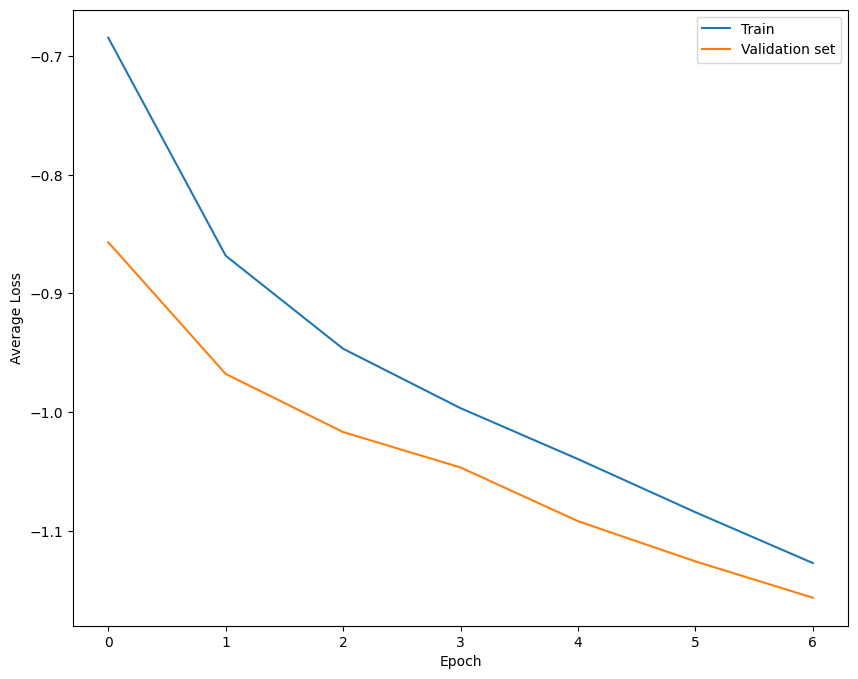

In [68]:
plt.figure(figsize=(10,8))
plt.plot(diz_loss['train_loss'], label='Train')
plt.plot(np.array(diz_loss['val_loss']), label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

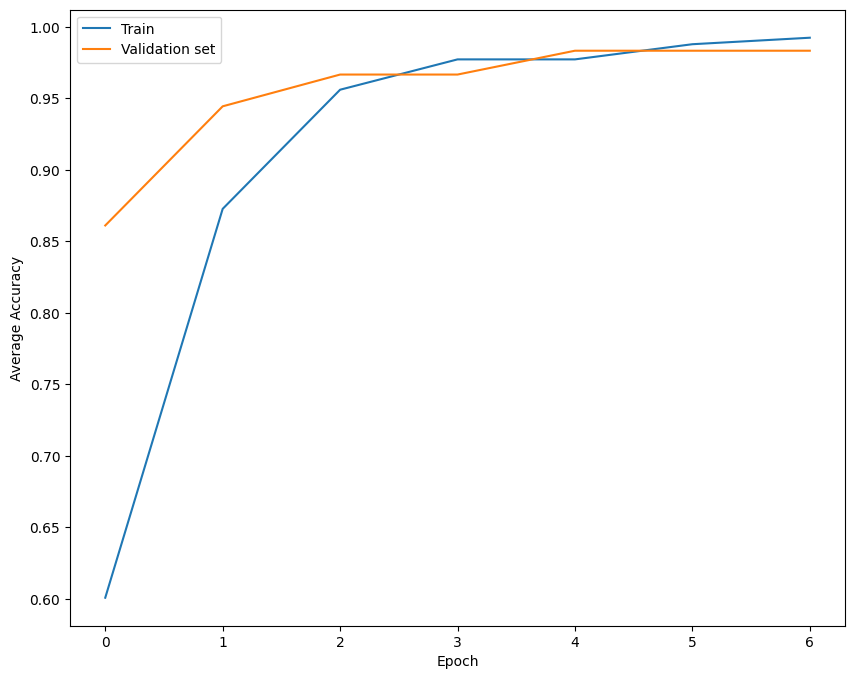

In [69]:
plt.figure(figsize=(10,8))
plt.plot(diz_acc['train_acc'], label='Train')
plt.plot(np.array(diz_acc['val_acc']), label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

Сравним время необходимое для обучения каждой из моделей. Для классической модели время одной эпохи в среднем составило 0.3 с , для гибридной модели с двумя кубитами - 25 с. , для гибридной модели с тремя кубитами - 75 сек. При этом все три модели выходили на максимальный уровень точности за 4-5 эпох. Точность на тесте составляла 0.72-0.75.